In [6]:
%pip install numpy pandas seaborn matplotlib

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
data = pd.read_csv('https://raw.githubusercontent.com/mariolpantunes/ml101/main/datasets/housing.csv')

In [9]:
data.shape

(1460, 63)

# Constant Features

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.drop(['SalePrice'], axis=1), 
                                                    data.SalePrice, test_size=0.3, 
                                                    random_state=0)

In [11]:
numerical_x_train = x_train[x_train.select_dtypes([np.number]).columns]

In [12]:
from sklearn.feature_selection import VarianceThreshold
vs_constant = VarianceThreshold(threshold=0)

In [13]:
vs_constant.fit(numerical_x_train)

VarianceThreshold(threshold=0)

In [14]:
len(x_train[x_train.select_dtypes([np.number]).columns].columns[vs_constant.get_support()])

35

In [15]:
constant_columns = [column for column in numerical_x_train.columns
                    if column not in numerical_x_train.columns[vs_constant.get_support()]]

In [16]:
len(constant_columns)

0

In [17]:
constant_cat_columns = [column for column in x_train.columns 
                        if (x_train[column].dtype == "O" and len(x_train[column].unique())  == 1 )]

In [18]:
all_constant_columns = constant_cat_columns + constant_columns

In [19]:
x_train.drop(labels=constant_columns, axis=1, inplace=True)
x_test.drop(labels=constant_columns, axis=1, inplace=True)

# Quasi Constant features

In [20]:
threshold = 0.98

# create empty list
quasi_constant_feature = []

# loop over all the columns
for feature in x_train.columns:

    # calculate the ratio.
    predominant = (x_train[feature].value_counts() / np.float(len(x_train))).sort_values(ascending=False).values[0]
    
    # append the column name if it is bigger than the threshold
    if predominant >= threshold:
        quasi_constant_feature.append(feature)   
        
print(quasi_constant_feature)

['Street', 'Utilities', 'Condition2', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


In [21]:
# drop the quasi constant columns
x_train.drop(labels=quasi_constant_feature, axis=1, inplace=True)
x_test.drop(labels=quasi_constant_feature, axis=1, inplace=True)

# Duplicated Features

In [22]:
train_features_T = x_train.T
train_features_T.head()

,64,682,960,1384,1100,416,1034,853,472,1011,328,608,1283,452,1227,530,1399,922,912,418,906,751,828,1296,901,1038,716,1069,1226,500,471,1447,487,1336,1177,131,15,1086,911,435,...,544,639,697,1289,1312,423,910,1171,659,797,1435,1201,99,850,448,755,976,115,777,72,845,537,849,174,87,551,705,314,1420,600,1094,599,277,1033,1383,763,835,1216,559,684
Id,65,683,961,1385,1101,417,1035,854,473,1012,329,609,1284,453,1228,531,1400,923,913,419,907,752,829,1297,902,1039,717,1070,1227,501,472,1448,488,1337,1178,132,16,1087,912,436,...,545,640,698,1290,1313,424,911,1172,660,798,1436,1202,100,851,449,756,977,116,778,73,846,538,850,175,88,552,706,315,1421,601,1095,600,278,1034,1384,764,836,1217,560,685
MSSubClass,60,120,20,50,30,60,30,80,180,90,75,70,90,60,20,80,50,20,30,50,20,60,60,20,20,160,70,45,60,160,60,60,20,90,50,60,45,160,20,60,...,60,120,20,60,60,60,90,20,20,20,20,60,20,120,50,160,30,160,20,60,85,20,80,20,160,20,190,70,60,60,20,160,20,20,30,60,20,90,120,60
MSZoning,RL,RL,RL,RL,RL,RL,RL,RL,RM,RL,RL,RL,RL,RL,RL,RL,RL,RL,RM,RL,RL,RL,RL,RL,RL,RM,RM,RL,RL,RM,RL,RL,RL,RL,RM,RL,RM,RM,RL,RL,...,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,RL,RM,RM,FV,RL,FV,RL,RL,RL,RL,RL,RL,FV,RM,RM,RM,RL,RL,RL,RM,RL,RL,RL,RL,RL,RM,RL,RL
LotFrontage,70.05,70.05,50,60,60,74,50,70.05,35,75,70.05,78,94,70.05,72,85,51,65,51,60,116,70.05,70.05,80,64,21,60,60,86,21,92,80,70,87,70.05,70.05,51,70.05,70.05,43,...,58,53,57,86,70.05,80,80,76,75,57,80,80,77,36,50,34,51,34,100,74,70.05,70.05,80,47,40,50,70,60,90,74,74,24,140,70.05,70.05,82,60,68,70.05,58
LotArea,9375,2887,7207,9060,8400,7844,6305,12095,3675,9825,11888,12168,9400,9303,8872,10200,6171,10237,6120,8160,13501,7750,28698,8700,8712,1533,10800,9600,14598,1890,11952,10000,12243,9246,3950,12224,6120,1974,9286,10667,...,17104,3982,6420,11065,9572,9200,11600,9120,9937,7677,8400,10400,9320,4435,8600,3230,5900,3230,13350,10141,16647,12735,9600,12416,3951,6000,5600,9600,11700,10927,5868,1950,19138,8125,25339,9430,9600,8930,3196,16770


In [23]:
print(train_features_T.duplicated().sum())

0


In [24]:
duplicated_columns = train_features_T[train_features_T.duplicated()].index.values

In [25]:
x_train.drop(labels=duplicated_columns, axis=1, inplace=True)
x_test.drop(labels=duplicated_columns, axis=1, inplace=True)

# Correlation methods

In [26]:
correlated_features = set()
correlation_matrix = x_train.corr()

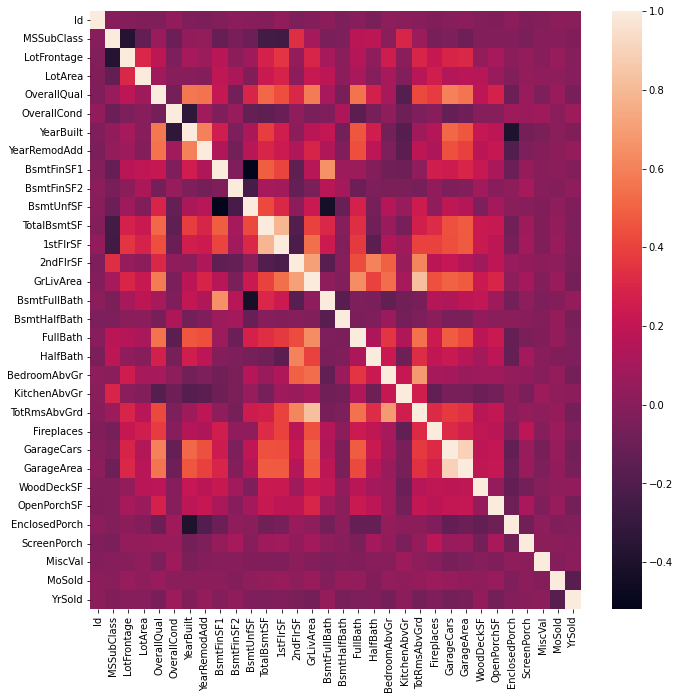

In [27]:
plt.figure(figsize=(11,11))
sns.heatmap(correlation_matrix)

In [28]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [29]:
correlated_features

{'GarageArea', 'TotRmsAbvGrd'}

In [30]:
x_train.drop(labels=correlated_features, axis=1, inplace=True)
x_test.drop(labels=correlated_features, axis=1, inplace=True)

# Statistical Measures

In [48]:
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

### Mutual Information

In [49]:
# select the number of features you want to retain.
select_k = 10

# get only the numerical features.
numerical_x_train = x_train[x_train.select_dtypes([np.number]).columns]


# create the SelectKBest with the mutual info strategy.
selection = SelectKBest(mutual_info_classif, k=select_k).fit(numerical_x_train, y_train)

# display the retained features.
features = x_train.select_dtypes([np.number]).columns[selection.get_support()]
print(features)

Index(['OverallQual', 'OverallCond', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars'],
      dtype='object')


### Chi Squared Score

In [52]:
# change this to how much features you want to keep from the top ones.
select_k = 10

# apply the chi2 score on the data and target (target should be binary).  
selection = SelectKBest(chi2, k=select_k).fit(numerical_x_train, y_train)

# display the k selected features.
features = x_train.select_dtypes([np.number]).columns[selection.get_support()]
print(features)

Index(['Id', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '2ndFlrSF', 'GrLivArea', 'ScreenPorch', 'MiscVal'],
      dtype='object')


### Univariate RMSE

In [55]:
def univariate_rmse():
    mse_values = []
    for feature in x_train.select_dtypes([np.number]).columns:
        clf = DecisionTreeRegressor()
        clf.fit(x_train[feature].to_frame(), y_train)
        y_scored = clf.predict(x_test[feature].to_frame())
        mse_values.append(mean_squared_error(y_test, y_scored))
    mse_values = pd.Series(mse_values)
    mse_values.index = x_train.select_dtypes([np.number]).columns
    print(mse_values.sort_values(ascending=False))
    print(len(mse_values[mse_values > threshold]),'out of the %s featues are kept'% len(x_train.select_dtypes([np.number]).columns))
    keep_col = mse_values[mse_values > threshold]
    return keep_col   

In [56]:
univariate_rmse()

Id               1.326803e+10
BsmtUnfSF        1.011789e+10
LotArea          8.379937e+09
BsmtFinSF1       7.696158e+09
WoodDeckSF       7.271460e+09
OpenPorchSF      6.886315e+09
MoSold           6.875928e+09
YrSold           6.832078e+09
LotFrontage      6.827291e+09
BsmtFinSF2       6.806977e+09
BsmtHalfBath     6.798179e+09
EnclosedPorch    6.797342e+09
MiscVal          6.791047e+09
ScreenPorch      6.707080e+09
KitchenAbvGr     6.665297e+09
BedroomAbvGr     6.642833e+09
1stFlrSF         6.496486e+09
BsmtFullBath     6.486271e+09
HalfBath         6.072529e+09
OverallCond      6.026309e+09
2ndFlrSF         5.816917e+09
TotalBsmtSF      5.669278e+09
Fireplaces       5.295673e+09
MSSubClass       5.258424e+09
GrLivArea        5.208607e+09
YearRemodAdd     5.138584e+09
YearBuilt        4.776575e+09
FullBath         4.740520e+09
GarageCars       3.524021e+09
OverallQual      2.097027e+09
dtype: float64
30 out of the 30 featues are kept


Id               1.326803e+10
MSSubClass       5.258424e+09
LotFrontage      6.827291e+09
LotArea          8.379937e+09
OverallQual      2.097027e+09
OverallCond      6.026309e+09
YearBuilt        4.776575e+09
YearRemodAdd     5.138584e+09
BsmtFinSF1       7.696158e+09
BsmtFinSF2       6.806977e+09
BsmtUnfSF        1.011789e+10
TotalBsmtSF      5.669278e+09
1stFlrSF         6.496486e+09
2ndFlrSF         5.816917e+09
GrLivArea        5.208607e+09
BsmtFullBath     6.486271e+09
BsmtHalfBath     6.798179e+09
FullBath         4.740520e+09
HalfBath         6.072529e+09
BedroomAbvGr     6.642833e+09
KitchenAbvGr     6.665297e+09
Fireplaces       5.295673e+09
GarageCars       3.524021e+09
WoodDeckSF       7.271460e+09
OpenPorchSF      6.886315e+09
EnclosedPorch    6.797342e+09
ScreenPorch      6.707080e+09
MiscVal          6.791047e+09
MoSold           6.875928e+09
YrSold           6.832078e+09
dtype: float64